# Multilayer Perceptron

This time we are following the MLP, following Bengio et al. 2003 paper to introduce MLP to the problem instead of using BiGrams for the makemore model.

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
with open('names.txt', 'r') as f:
  words = f.read().splitlines()

### Build the dataset
As described in the paper, the `context length` is set to 3. Also the embedding look up table `c` is built using random numbers ~ 𝒩(0, 1)

In [ ]:
# build the vocabulary of characters & encoding/decoding
chars = sorted(list(set(''.join(words))))

stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}

In [ ]:
# build the dataset

block_size = 3    # context length, according to paper
X, Y = [], []
for w in words:
  print(w)
  context = [0] * block_size
  for ch in w+'.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    # print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix]    # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)
X.shape

### Embedding Look up table
Embeddin for a number, say 5 is just `C[5]`. Equivalently it can be achieved using \
`torch.nn.functional.one_hot(torch.tensor(5), num_classes=27).float() @ C`.

In [ ]:
# ------------ Doesn't work ----------------
# because the dimensions don't match
# emb @ W1 + b1

# ------------ This works -------------------
# torch.cat(torch.unbind(emb, dim=1), dim=1).shape
# h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

### Our model

In [ ]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)

parameters = [C, W2, b1, W2, b2]

# number of parameters in our model
sum(p.nelement() for p in parameters)

In [ ]:
for p in parameters:
  p.requires_grad = True

In [ ]:

for _ in range(10000):
  # minibatch construct
  ix = torch.randint(0, X.shape[0], (32,))

  # forward pass
  # emb = C[X]    # shape: (32, 3, 2)
  emb = C[X[ix]]  # shape: (32, 3, 2)
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1)   # (32, 100)
  logits = h @ W2 + b2        # (32, 27)
  loss = F.cross_entropy(logits, Y[ix])

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  for p in parameters:
    p.data += -0.1 * p.grad
# print(loss.item())

 Train, Val, Test split


In [ ]:
# build the dataset
def build_dataset(words):
  block_size = 3
  X, Y = [], []
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [ ]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)

parameters = [C, W1, b1, W2, b2]

# number of parameters in our model
sum(p.nelement() for p in parameters)

In [ ]:
for p in parameters:
  p.requires_grad = True

In [ ]:

for _ in range(10000):
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))

  # forward pass
  # emb = C[X]    # shape: (32, 3, 2)
  emb = C[Xtr[ix]]  # shape: (32, 3, 2)
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1)   # (32, 100)
  logits = h @ W2 + b2        # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.01
  for p in parameters:
    p.data += -lr * p.grad
# print(loss.item())

In [ ]:
print(loss.item())

2.385051727294922


In [ ]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.3592, grad_fn=<NllLossBackward0>)

# Train a Bigger Model

In [ ]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g)      # embedding space: 2 -> 10
W1 = torch.randn((30, 200), generator=g)    # hidden layer neurons: 100 -> 200
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [ ]:
# number of parameters in our model
sum(p.nelement() for p in parameters)

11897

In [ ]:
for p in parameters:
  p.requires_grad = True

In [ ]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [ ]:
lri = []
lossi = []
stepi = []

In [ ]:
for i in range(2000):
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (64,))    # batch size: 32 -> 64

  # forward pass
  emb = C[Xtr[ix]]  # shape: (64, 3, 2)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1)   # (64, 100)
  logits = h @ W2 + b2        # (64, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  # print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  # lr = lrs[i]
  lr = 0.01

  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  # lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())
# print(loss.item())

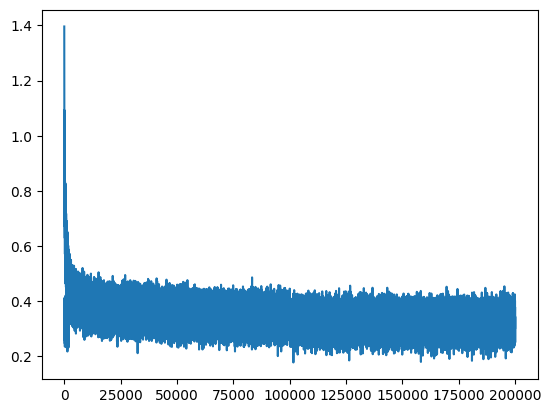

In [ ]:
plt.plot(stepi, lossi)

In [ ]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1203, grad_fn=<NllLossBackward0>)

In [ ]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1663, grad_fn=<NllLossBackward0>)

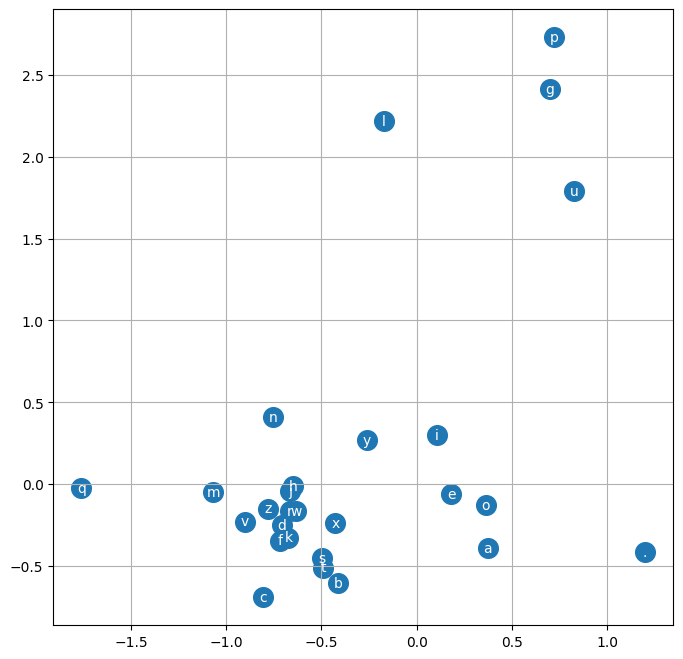

In [ ]:
# Run only if embedding space is 2 dimensional

plt.figure(figsize=(8,8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
  plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha='center', va='center', color='white')
plt.grid('minor')

# Possible bottlencks:
* small model size
* small batch size
* quite dense embedding
* context size
* learning rate, decay rate, etc.

# Sampling from the model
* start with empty context `[* * *]`
* generate probability distribution
* sample from it till next prediction is `*`

In [ ]:
g = torch.Generator().manual_seed(2147483647+10)
block_size = 3      # context length


# sample 20 names from the model
for _ in range(20):
  out = []
  context = [0] * block_size
  while True:
    emb = C[torch.tensor([context])]      # (1, block_size, d)
    h = torch.tanh(emb.view(1, -1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)      # prob space for each character
    ix = torch.multinomial(probs, num_samples=1, generator=g).item()
    context = context[1:] + [ix]
    out.append(itos[ix])
    if ix == 0:
      break

  print(''.join(out))

mondalmyah.
see.
mad.
rylle.
emmadiejd.
leg.
adelyn.
elin.
shi.
jen.
eden.
estanarielle.
malaia.
noshibergihiriel.
kindrenleighnteromi.
bren.
dariyah.
faeha.
kayjahson.
daihia.
